In [1]:
%pip install pillow transformers torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
from transformers import AutoProcessor, AutoModel
import torch

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained("google/medsiglip-448").to(device)
processor = AutoProcessor.from_pretrained("google/medsiglip-448")

def crop_and_resize(img, size=(448, 448)):
    w, h = img.size
    aspect = size[0] / size[1]
    img_aspect = w / h

    if img_aspect > aspect:
        # Crop width
        new_w = int(h * aspect)
        left = (w - new_w) // 2
        img = img.crop((left, 0, left + new_w, h))
    else:
        # Crop height
        new_h = int(w / aspect)
        top = (h - new_h) // 2
        img = img.crop((0, top, w, top + new_h))
    return img.resize(size, Image.BILINEAR)


/Users/swichchattrapong/miniconda3/envs/google/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


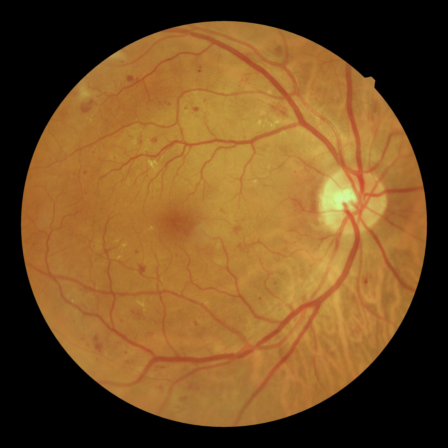

6.11% of 'No DR'
16.20% of 'Mild DR'
33.78% of 'Moderate DR'
24.43% of 'Severe DR'
19.48% of 'PDR'
Predicted class: Moderate DR (33.78% confidence)
----------------------------------------


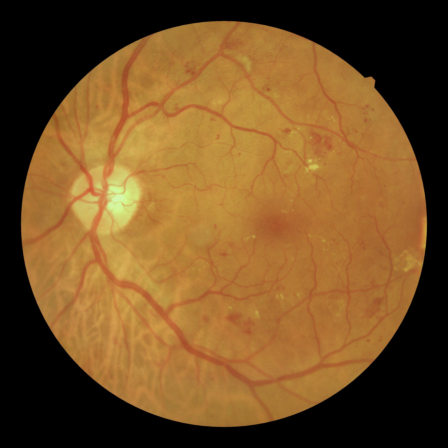

6.87% of 'No DR'
14.57% of 'Mild DR'
28.74% of 'Moderate DR'
29.32% of 'Severe DR'
20.50% of 'PDR'
Predicted class: Severe DR (29.32% confidence)
----------------------------------------


In [2]:
image_names = ["1.jpg", "2.jpg"]
imgs = [crop_and_resize(Image.open(name).convert("RGB")) for name in image_names]

texts = [
    "A fundus photograph of a healthy retina with no signs of diabetic retinopathy.",
    "A fundus photograph showing mild non-proliferative diabetic retinopathy, characterized by a few microaneurysms.",
    "A fundus photograph showing moderate non-proliferative diabetic retinopathy, with multiple microaneurysms, dot-blot hemorrhages, and cotton wool spots.",
    "A fundus photograph showing severe non-proliferative diabetic retinopathy, with extensive hemorrhages, venous beading, or intraretinal microvascular abnormalities (IRMA).",
    "A fundus photograph showing proliferative diabetic retinopathy, characterized by neovascularization (growth of new, abnormal blood vessels).",
]

short_texts = [
    "No DR",
    "Mild DR",
    "Moderate DR",
    "Severe DR",
    "PDR",
]


inputs = processor(text=texts, images=imgs, padding="max_length", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.softmax(logits_per_image, dim=1)

for n_img, img in enumerate(imgs):
    display(img)
    for i, label in enumerate(short_texts):
        print(f"{probs[n_img][i]:.2%} of '{label}'")

    max_prob, max_idx = torch.max(probs[n_img], dim=0)
    print(f"Predicted class: {short_texts[max_idx]} ({max_prob:.2%} confidence)")
    print("-" * 40)
